<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session11/FinalS11Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Albumentation and Apex Package**

In [1]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"


  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-elpf_qf2
Albumentation library is successfully installed!


## **Mount Drive and Unzip data**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive


In [3]:
import sys
folder = '/content/gdrive/My Drive/Colab Notebooks/eva5/Session11/api'
sys.path.append(folder)
folder = "/content/gdrive/My Drive/Colab Notebooks/eva5/Session11/api/Models"
sys.path.append(folder)

## **Import required modules**

In [4]:

import torch
import train_test_loader
import show_images
from NewResnetModel import NewResnet
import train_test
import evaluate
from Albumentationtransform import AlbumentationTransforms
from GradCam import GradCAM,visualize_cam
from LR_Range_Test import LR_test

## **Abumentation Transforms**

In [5]:
import albumentations as A
import cv2
channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([                                      
                                      A.PadIfNeeded(min_height=36, min_width=36, border_mode = cv2.BORDER_REFLECT, always_apply=True,),
                                      A.RandomCrop(height=32, width=32, always_apply=True),
                                      A.HorizontalFlip(p = 0.7),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


## **Load Train Test Data**

In [6]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform,batch_size=512)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **Some training data**

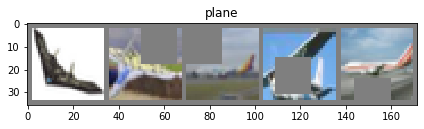

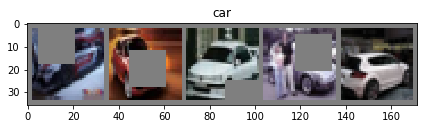

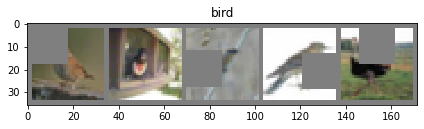

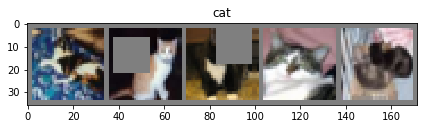

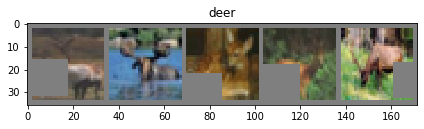

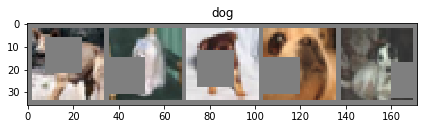

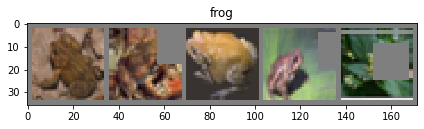

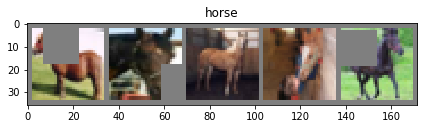

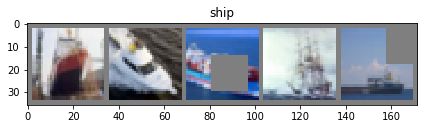

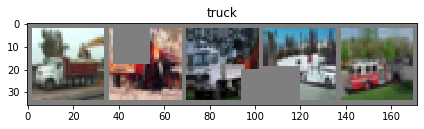

In [7]:
show_images.show_train_data(trainloader, classes)

## **Print Model Summary**

In [8]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = NewResnet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## **LR Range Test**

epoch = 1 Lr = 0.001  Loss=1.4524266719818115 Batch_id=97 Accuracy=37.07: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
epoch = 2 Lr = 0.0029  Loss=1.326030969619751 Batch_id=97 Accuracy=44.28: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
epoch = 3 Lr = 0.0048  Loss=1.2402790784835815 Batch_id=97 Accuracy=41.95: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
epoch = 4 Lr = 0.006699999999999999  Loss=1.1880587339401245 Batch_id=97 Accuracy=41.22: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
epoch = 5 Lr = 0.0086  Loss=1.742103934288025 Batch_id=97 Accuracy=23.24: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
epoch = 6 Lr = 0.0105  Loss=1.732835292816162 Batch_id=97 Accuracy=23.20: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
epoch = 7 Lr = 0.012400000000000001  Loss=1.7117409706115723 Batch_id=97 Accuracy=22.04: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
epoch = 8 Lr = 0.014300000000000002  Loss=1.7449827194213867 Batch_id=97 Accuracy=22.02: 100%|██████████| 98/98 [01

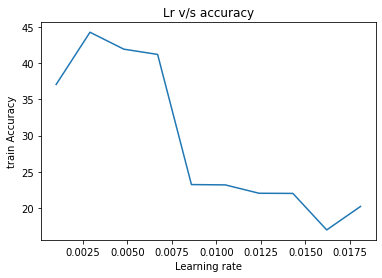

In [9]:
import torch.nn as nn
max_lr = 0.02
min_lr = 0.001
epoch = 10
criterion = nn.NLLLoss()
LR_test(max_lr, min_lr,device,epoch,model,criterion,trainloader,momemtum = 0.9,weight_decay=0.05, plot= True )


  

## **Initialise Loss funtion, Optimizer, Schedular**

In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
model = NewResnet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=0.005 ) 
criterion = nn.NLLLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.0125, total_steps=None, epochs=24, steps_per_epoch=len(trainloader), pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

## **Model Training**

In [11]:
train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,24,scheduler,batch_scheduler=True,best_acc = 0,path = "/content/gdrive/My Drive/Colab Notebooks/eva5/Session11/api/Models/apibestmodel.pt") 

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.00125


Loss=1.2398056983947754 Batch_id=97 Accuracy=40.68: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]



Test set: Average loss: 0.0027, Accuracy: 5054/10000 (50.54%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.004064050599309824


Loss=1.0120352506637573 Batch_id=97 Accuracy=57.64: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]



Test set: Average loss: 0.0019, Accuracy: 6660/10000 (66.60%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3 LR: 0.006878101198619647


Loss=1.0256909132003784 Batch_id=97 Accuracy=65.22: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0020, Accuracy: 6800/10000 (68.00%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4 LR: 0.00969215179792947


Loss=0.6647873520851135 Batch_id=97 Accuracy=69.97: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]



Test set: Average loss: 0.0016, Accuracy: 7326/10000 (73.26%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 5 LR: 0.01249875970796482


Loss=0.8071404695510864 Batch_id=97 Accuracy=74.21: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0014, Accuracy: 7651/10000 (76.51%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 6 LR: 0.011936034617928805


Loss=0.5392247438430786 Batch_id=97 Accuracy=78.10: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]



Test set: Average loss: 0.0012, Accuracy: 8001/10000 (80.01%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 7 LR: 0.01137330952789279


Loss=0.5713521838188171 Batch_id=97 Accuracy=80.90: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0011, Accuracy: 8206/10000 (82.06%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 8 LR: 0.010810584437856777


Loss=0.4954553246498108 Batch_id=97 Accuracy=82.47: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8041/10000 (80.41%)

EPOCH: 9 LR: 0.010247859347820762


Loss=0.5545517802238464 Batch_id=97 Accuracy=84.69: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0010, Accuracy: 8287/10000 (82.87%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 10 LR: 0.009685134257784746


Loss=0.4127177298069 Batch_id=97 Accuracy=85.66: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]



Test set: Average loss: 0.0008, Accuracy: 8567/10000 (85.67%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 11 LR: 0.009122409167748733


Loss=0.3279447555541992 Batch_id=97 Accuracy=86.91: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0008, Accuracy: 8682/10000 (86.82%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 12 LR: 0.00855968407771272


Loss=0.3901057541370392 Batch_id=97 Accuracy=87.97: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8655/10000 (86.55%)

EPOCH: 13 LR: 0.007996958987676703


Loss=0.34985291957855225 Batch_id=97 Accuracy=88.95: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8661/10000 (86.61%)

EPOCH: 14 LR: 0.007434233897640689


Loss=0.336749792098999 Batch_id=97 Accuracy=89.85: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0007, Accuracy: 8827/10000 (88.27%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 15 LR: 0.006871508807604675


Loss=0.28913766145706177 Batch_id=97 Accuracy=90.51: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8807/10000 (88.07%)

EPOCH: 16 LR: 0.006308783717568661


Loss=0.22427663207054138 Batch_id=97 Accuracy=91.21: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]



Test set: Average loss: 0.0007, Accuracy: 8893/10000 (88.93%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 17 LR: 0.005746058627532647


Loss=0.22323539853096008 Batch_id=97 Accuracy=91.67: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8881/10000 (88.81%)

EPOCH: 18 LR: 0.0051833335374966314


Loss=0.19253985583782196 Batch_id=97 Accuracy=92.40: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]



Test set: Average loss: 0.0007, Accuracy: 8917/10000 (89.17%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 19 LR: 0.004620608447460617


Loss=0.1890397071838379 Batch_id=97 Accuracy=93.22: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0006, Accuracy: 9010/10000 (90.10%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 20 LR: 0.004057883357424602


Loss=0.23127853870391846 Batch_id=97 Accuracy=93.51: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8951/10000 (89.51%)

EPOCH: 21 LR: 0.003495158267388587


Loss=0.20260512828826904 Batch_id=97 Accuracy=94.22: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9003/10000 (90.03%)

EPOCH: 22 LR: 0.0029324331773525735


Loss=0.1649598330259323 Batch_id=97 Accuracy=94.68: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0005, Accuracy: 9101/10000 (91.01%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 23 LR: 0.0023697080873165584


Loss=0.14206041395664215 Batch_id=97 Accuracy=95.06: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8996/10000 (89.96%)

EPOCH: 24 LR: 0.0018069829972805432


Loss=0.15833404660224915 Batch_id=97 Accuracy=95.68: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0005, Accuracy: 9121/10000 (91.21%)

accuracy increased, Saving model....


## **Load the Best Accuracy Model**

In [12]:

model = NewResnet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/Colab Notebooks/eva5/Session11/api/Models/apibestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
print("Loaded the best model")

Loaded the best model


In [13]:
evaluate.evaluate_accuracy(model,device,testloader)

Accuracy of the network on the 10000 test images: 91.21 %


## **class wise accuracy**

In [14]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 86 %
Accuracy of   cat : 73 %
Accuracy of  deer : 92 %
Accuracy of   dog : 92 %
Accuracy of  frog : 95 %
Accuracy of horse : 91 %
Accuracy of  ship : 95 %
Accuracy of truck : 94 %


## **Plot accurary change in test and train**

No handles with labels found to put in legend.


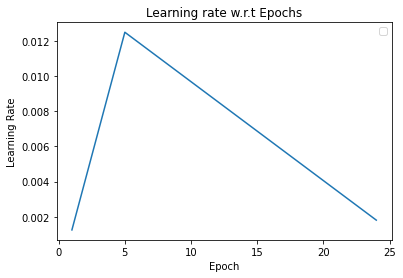

In [15]:
import numpy as np
curves = [{"x":np.arange(1,25), "y": train_test.LR, "label": "","xlabel": "Epoch", "ylabel":"Learning Rate"}]
evaluate.plot_curve(curves,"Learning rate w.r.t Epochs",Figsize = (6,4))


## **Extract 25 misclassified_images**

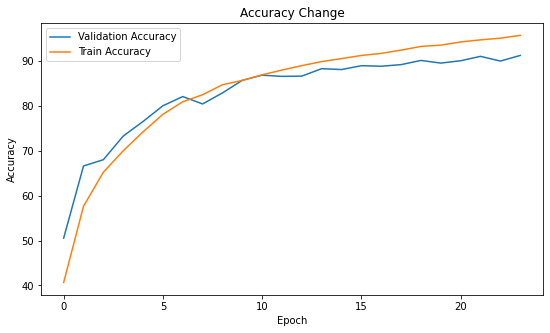

In [16]:
curves = [{"y":train_test.test_acc , "label": "Validation Accuracy","xlabel": "Epoch", "ylabel":"Accuracy" },{"y":train_test.train_acc , "label": "Train Accuracy","xlabel": "Epoch", "ylabel":"Accuracy" }]
evaluate.plot_curve(curves,"Accuracy Change",Figsize = (9,5))


## **GradCam on misclassified images**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


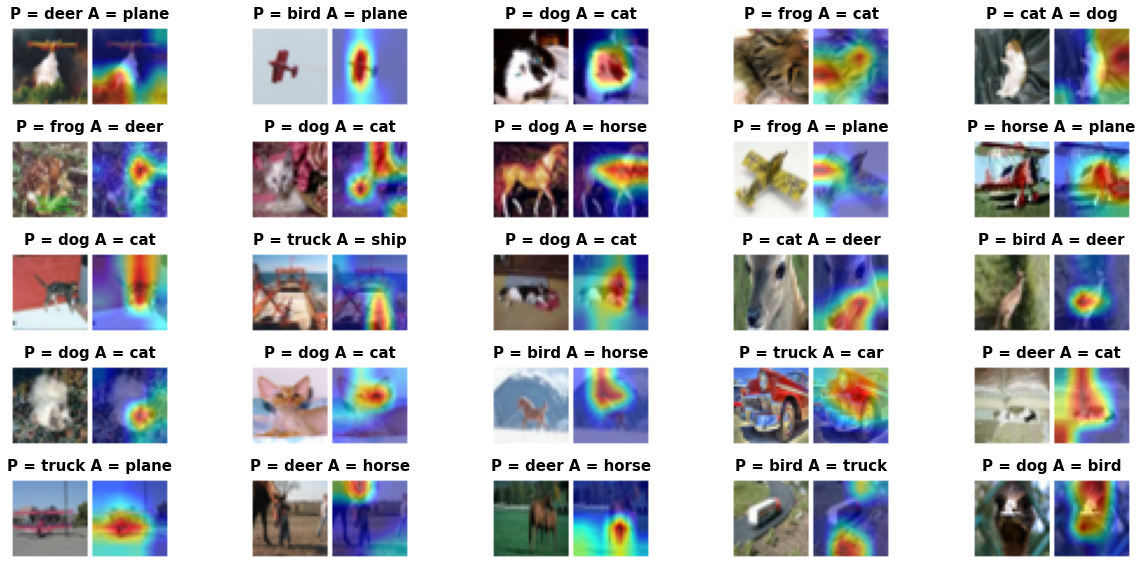

In [17]:

from GradCam import GradCamView
layers = [model.R2]
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)
GradCamView(miscalssified_images,model,classes,layers,Figsize = (17,8),subplotx1 = 5, subplotx2 = 5)
